### Epochs = 20, Learning rate = 0.0001, batch size = 16, image size = 128 x128 + data augmentations
### Adding weighting to loss function to account for cat class imbalance (x2.1 to cat class since dataset has approx x2.1 more dog samples than cat samples)

##### Conclusions: large improvement in iou for cats

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates

# Set random seed for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class JointTransform:
    def __init__(self, img_size=128, crop_size=112, p_flip=0.5, p_rotate=0.3, p_elastic=0.3):
        self.img_size = img_size
        self.crop_size = crop_size
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.p_elastic = p_elastic
        
        # For elastic transform
        self.elastic_alpha = 25
        self.elastic_sigma = 3
    
    def __call__(self, image, mask):
        # Resize both to same size
        image = TF.resize(image, (self.img_size, self.img_size))
        mask = TF.resize(mask, (self.img_size, self.img_size), interpolation=TF.InterpolationMode.NEAREST)
        
        # Random horizontal flip
        if random.random() < self.p_flip:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
            
        # Random rotation (-30 to 30 degrees)
        if random.random() < self.p_rotate:
            angle = random.uniform(-30, 30)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)
            
        # Random crop (ensures consistent crop for both)
        i, j, h, w = transforms.RandomCrop.get_params(image, (self.crop_size, self.crop_size))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        
        # Random translation (via padding + crop)
        pad_max = self.img_size // 10
        if pad_max > 0:
            pad_left = random.randint(0, pad_max)
            pad_top = random.randint(0, pad_max)
            pad_right = random.randint(0, pad_max)
            pad_bottom = random.randint(0, pad_max)
            image = TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom))
            mask = TF.pad(mask, (pad_left, pad_top, pad_right, pad_bottom), fill=255)
            
            # Crop back to original size
            image = TF.center_crop(image, (self.img_size, self.img_size))
            mask = TF.center_crop(mask, (self.img_size, self.img_size))
        
        # Elastic transformation (only if probability threshold met)
        if random.random() < self.p_elastic:
            image, mask = self._elastic_transform(image, mask)
        
        # Color jitter (image only)
        image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
        image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
        image = TF.adjust_saturation(image, random.uniform(0.8, 1.2))
        
        # Convert to tensor
        image = TF.to_tensor(image)
        mask = torch.from_numpy(np.array(mask)).long()
        
        return image, mask
    
    def _elastic_transform(self, image, mask):
        """Apply elastic transformation on image and mask"""
        image_np = np.array(image)
        mask_np = np.array(mask)
        
        # Create displacement fields
        shape = image_np.shape[:2]
        dx = np.random.rand(*shape) * 2 - 1
        dy = np.random.rand(*shape) * 2 - 1
        
        # Smooth displacement fields
        dx = gaussian_filter(dx, sigma=self.elastic_sigma) * self.elastic_alpha
        dy = gaussian_filter(dy, sigma=self.elastic_sigma) * self.elastic_alpha
        
        # Create mesh grid
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
        
        # Apply displacement on image
        distorted_image = np.zeros(image_np.shape)
        for c in range(3):
            distorted_image[:,:,c] = map_coordinates(image_np[:,:,c], indices, order=1).reshape(shape)
        
        # Apply displacement on mask (using nearest to preserve labels)
        distorted_mask = map_coordinates(mask_np, indices, order=0).reshape(shape)
        
        return Image.fromarray(distorted_image.astype(np.uint8)), Image.fromarray(distorted_mask.astype(np.uint8))

In [3]:
class PetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with the dataset.
            split (string): 'train', 'val', or 'test' split.
            transform (callable, optional): Transform to be applied on the input image.
            target_transform (callable, optional): Transform to be applied on the mask.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        
        # Set paths for images and masks
        self.image_dir = os.path.join(root_dir, split, 'color')
        self.mask_dir = os.path.join(root_dir, split, 'label')
        
        # Get all image file names
        self.image_files = sorted([f for f in os.listdir(self.image_dir) 
                                  if os.path.isfile(os.path.join(self.image_dir, f))])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Get corresponding mask file
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        
        # Load and process mask
        mask = Image.open(mask_path).convert('RGB')
        mask_np = np.array(mask)
        
        # Convert RGB mask to class indices
        seg_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
        
        # Background (black)
        black_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[black_mask] = 0
        # Cat (red)
        red_mask = (mask_np[:,:,0] == 128) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
        seg_mask[red_mask] = 1
        # Dog (green)
        green_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 128) & (mask_np[:,:,2] == 0)
        seg_mask[green_mask] = 2
        # White border (ignore)
        white_mask = (mask_np[:,:,0] == 255) & (mask_np[:,:,1] == 255) & (mask_np[:,:,2] == 255)
        seg_mask[white_mask] = 255  # Use 255 as ignore index
        
        # Create a PIL Image from the segmentation mask
        seg_mask_pil = Image.fromarray(seg_mask)
        
        # Apply joint transformations
        if self.transform:
            image, seg_mask = self.transform(image, seg_mask_pil)
        else:
            # Convert to tensor if no transform
            image = TF.to_tensor(Image.fromarray(np.array(image)))
            seg_mask = torch.from_numpy(seg_mask).long()
        
        return image, seg_mask

In [4]:
# Define image sizes
img_size = 128
crop_size = 112

# Create transforms
joint_transform_train = JointTransform(img_size=img_size, crop_size=crop_size)

# Simple transform for validation/test (no augmentation)
def val_transform(image, mask):
    # Resize both to same size
    image = TF.resize(image, (img_size, img_size))
    mask = TF.resize(mask, (img_size, img_size), interpolation=TF.InterpolationMode.NEAREST)
    # Convert to tensor
    image = TF.to_tensor(image)
    mask = torch.from_numpy(np.array(mask)).long()
    return image, mask

# Create datasets
data_root = '../Dataset/'  # Adjust path as needed
trainval_dataset = PetDataset(data_root, 'TrainVal', transform=joint_transform_train)
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size

# For training/validation split
train_indices, val_indices = torch.utils.data.random_split(
    range(len(trainval_dataset)), [train_size, val_size]
)

# Create datasets with appropriate transforms
train_dataset = PetDataset(data_root, 'TrainVal', transform=joint_transform_train)
train_dataset.image_files = [trainval_dataset.image_files[i] for i in train_indices.indices]

val_dataset = PetDataset(data_root, 'TrainVal', transform=val_transform)
val_dataset.image_files = [trainval_dataset.image_files[i] for i in val_indices.indices]

test_dataset = PetDataset(data_root, 'Test', transform=val_transform)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Training set size: 2944
Validation set size: 736
Test set size: 3710


In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features_start=32):
        super(UNet, self).__init__()
        
        # Starting with 128x128 input
        # After 4 max pools of stride 2: 128 -> 64 -> 32 -> 16 -> 8
        
        # Encoder (Downsampling)
        self.encoder1 = DoubleConv(in_channels, features_start)  # 128 -> 128
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.encoder2 = DoubleConv(features_start, features_start*2)  # 64 -> 64
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
        self.encoder3 = DoubleConv(features_start*2, features_start*4)  # 32 -> 32
        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16
        self.encoder4 = DoubleConv(features_start*4, features_start*8)  # 16 -> 16
        self.pool4 = nn.MaxPool2d(2)  # 16 -> 8
        
        # Bottom
        self.bottom = DoubleConv(features_start*8, features_start*16)  # 8 -> 8
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)  # 8 -> 16
        self.decoder4 = DoubleConv(features_start*16, features_start*8)  # 16 -> 16
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)  # 16 -> 32
        self.decoder3 = DoubleConv(features_start*8, features_start*4)  # 32 -> 32
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)  # 32 -> 64
        self.decoder2 = DoubleConv(features_start*4, features_start*2)  # 64 -> 64
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)  # 64 -> 128
        self.decoder1 = DoubleConv(features_start*2, features_start)  # 128 -> 128
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)  # 128 -> 128

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 128
        enc2 = self.encoder2(self.pool1(enc1))  # 64
        enc3 = self.encoder3(self.pool2(enc2))  # 32
        enc4 = self.encoder4(self.pool3(enc3))  # 16
        
        # Bottom
        bottom = self.bottom(self.pool4(enc4))  # 8
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottom)  # 16
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)  # 32
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)  # 64
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)  # 128
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

In [6]:
def train_unet(model, train_loader, val_loader, num_epochs=30, cat_weight=2.1, device=device):
    """
    Train the U-Net model.
    
    Args:
        model: U-Net model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
        device: Device to train on
        
    Returns:
        Trained model
    """

    # Define class weights to address class imbalance [background, cat, dog]
    class_weights = torch.tensor([1.0, cat_weight, 1.0], device=device)

    # Define loss function with class weights and ignore_index for white pixels
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Learning rate scheduler - removed verbose parameter
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Track best model
    best_val_loss = float('inf')
    best_model = None
    
    # Training history
    train_losses = []
    val_losses = []
    prev_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss (outputs shape: [B, C, H, W], masks shape: [B, H, W])
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track loss
            running_loss += loss.item() * images.size(0)
        
        # Calculate average training loss
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Track loss
                val_running_loss += loss.item() * images.size(0)
        
        # Calculate average validation loss
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Manually check for learning rate changes
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f"Learning rate changed from {prev_lr:.6f} to {current_lr:.6f}")
            prev_lr = current_lr
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"LR: {current_lr:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            print(f"New best model saved with validation loss: {val_loss:.4f}")
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model

Training U-Net...


Epoch 1/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.03it/s]


Epoch [1/20], Train Loss: 0.8064, Val Loss: 0.7021, LR: 0.000100
New best model saved with validation loss: 0.7021


Epoch 2/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.89it/s]


Epoch [2/20], Train Loss: 0.6632, Val Loss: 0.6178, LR: 0.000100
New best model saved with validation loss: 0.6178


Epoch 3/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.95it/s]


Epoch [3/20], Train Loss: 0.6078, Val Loss: 0.5728, LR: 0.000100
New best model saved with validation loss: 0.5728


Epoch 4/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.84it/s]


Epoch [4/20], Train Loss: 0.5613, Val Loss: 0.4985, LR: 0.000100
New best model saved with validation loss: 0.4985


Epoch 5/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.82it/s]


Epoch [5/20], Train Loss: 0.5188, Val Loss: 0.4912, LR: 0.000100
New best model saved with validation loss: 0.4912


Epoch 6/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.04it/s]


Epoch [6/20], Train Loss: 0.4885, Val Loss: 0.4361, LR: 0.000100
New best model saved with validation loss: 0.4361


Epoch 7/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.04it/s]


Epoch [7/20], Train Loss: 0.4378, Val Loss: 0.5149, LR: 0.000100


Epoch 8/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.97it/s]


Epoch [8/20], Train Loss: 0.4164, Val Loss: 0.4017, LR: 0.000100
New best model saved with validation loss: 0.4017


Epoch 9/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.97it/s]


Epoch [9/20], Train Loss: 0.3902, Val Loss: 0.3614, LR: 0.000100
New best model saved with validation loss: 0.3614


Epoch 10/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.91it/s]


Epoch [10/20], Train Loss: 0.3741, Val Loss: 0.3211, LR: 0.000100
New best model saved with validation loss: 0.3211


Epoch 11/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.84it/s]


Epoch [11/20], Train Loss: 0.3535, Val Loss: 0.3107, LR: 0.000100
New best model saved with validation loss: 0.3107


Epoch 12/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.06it/s]


Epoch [12/20], Train Loss: 0.3465, Val Loss: 0.2861, LR: 0.000100
New best model saved with validation loss: 0.2861


Epoch 13/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.95it/s]


Epoch [13/20], Train Loss: 0.3152, Val Loss: 0.2955, LR: 0.000100


Epoch 14/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.97it/s]


Epoch [14/20], Train Loss: 0.2948, Val Loss: 0.3086, LR: 0.000100


Epoch 15/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.05it/s]


Epoch [15/20], Train Loss: 0.2858, Val Loss: 0.2795, LR: 0.000100
New best model saved with validation loss: 0.2795


Epoch 16/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.07it/s]


Epoch [16/20], Train Loss: 0.2827, Val Loss: 0.2679, LR: 0.000100
New best model saved with validation loss: 0.2679


Epoch 17/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.01it/s]


Epoch [17/20], Train Loss: 0.2610, Val Loss: 0.2905, LR: 0.000100


Epoch 18/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.08it/s]


Epoch [18/20], Train Loss: 0.2593, Val Loss: 0.2622, LR: 0.000100
New best model saved with validation loss: 0.2622


Epoch 19/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 11.08it/s]


Epoch [19/20], Train Loss: 0.2489, Val Loss: 0.2528, LR: 0.000100
New best model saved with validation loss: 0.2528


Epoch 20/20 (Val): 100%|██████████| 46/46 [00:04<00:00, 10.82it/s]


Epoch [20/20], Train Loss: 0.2397, Val Loss: 0.2685, LR: 0.000100


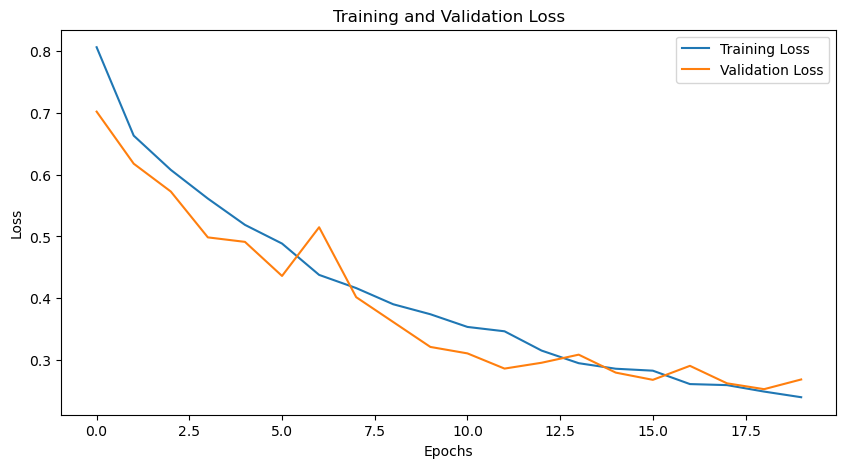

Model saved to unet_pet_segmentation.pth


In [7]:
# Create U-Net model with 3 output channels (background, cat, dog)
unet = UNet(in_channels=3, out_channels=3).to(device)

# Train U-Net model
print("Training U-Net...")
num_epochs = 20  # Adjust as needed
cat_weight = 2.1
unet = train_unet(unet, train_loader, val_loader, num_epochs=num_epochs, cat_weight=cat_weight, device=device)

# Save the trained model
torch.save(unet.state_dict(), 'unet_pet_segmentation.pth')
print("Model saved to unet_pet_segmentation.pth")

In [8]:
def evaluate_unet(model, dataloader, device):
    """
    Evaluate the U-Net model.
    
    Args:
        model: U-Net model
        dataloader: DataLoader for evaluation data
        device: Device to evaluate on
        
    Returns:
        Dictionary of evaluation metrics
    """
    model.eval()
    
    # Initialize metrics
    correct = 0
    total = 0
    
    # Initialize IoU metrics - one for each class
    num_classes = 3  # background (0), cat (1), dog (2)
    intersection = torch.zeros(num_classes, device=device)
    union = torch.zeros(num_classes, device=device)
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy (ignoring white pixels with value 255)
            mask = (masks != 255)
            correct += (predicted[mask] == masks[mask]).sum().item()
            total += mask.sum().item()
            
            # Calculate IoU for each class
            for cls in range(num_classes):
                pred_cls = (predicted == cls) & mask
                true_cls = (masks == cls) & mask
                
                # Intersection and union
                intersection[cls] += (pred_cls & true_cls).sum().item()
                union[cls] += (pred_cls | true_cls).sum().item()
    
    # Calculate metrics
    accuracy = correct / total if total > 0 else 0
    
    # Calculate IoU for each class
    class_names = ["background", "cat", "dog"]
    class_ious = []
    
    for cls in range(num_classes):
        iou = intersection[cls] / union[cls] if union[cls] > 0 else 0
        class_ious.append(iou)
        print(f"IoU for {class_names[cls]}: {iou:.4f}")
    
    # Calculate mean IoU
    mean_iou = sum(class_ious) / len(class_ious)
    
    print(f"Pixel Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    return {
        "pixel_accuracy": accuracy,
        "class_ious": {class_names[i]: class_ious[i] for i in range(num_classes)},
        "mean_iou": mean_iou
    }

In [9]:
# Evaluate model on validation set
print("\nEvaluating U-Net on validation set:")
val_results = evaluate_unet(unet, val_loader, device)


Evaluating U-Net on validation set:


Evaluating: 100%|██████████| 46/46 [00:04<00:00, 10.05it/s]

IoU for background: 0.9016
IoU for cat: 0.6409
IoU for dog: 0.7506
Pixel Accuracy: 0.9065
Mean IoU: 0.7643


In [10]:
def visualize_unet_results(model, dataloader, device, num_samples=3):
    """
    Visualize the U-Net model predictions.
    
    Args:
        model: U-Net model
        dataloader: DataLoader for visualization data
        device: Device to visualize on
        num_samples: Number of samples to visualize
    """
    model.eval()
    
    # Get a batch of samples
    dataiter = iter(dataloader)
    images, masks = next(dataiter)
    
    # Make sure we don't visualize more than what's available
    num_samples = min(num_samples, images.size(0))
    
    # Class colors for visualization
    colors = torch.tensor([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=torch.uint8)
    
    with torch.no_grad():
        # Get predictions
        outputs = model(images[:num_samples].to(device))
        _, predicted = torch.max(outputs, 1)
        
        # Create visualization
        fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i in range(num_samples):
            # Original image
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axs[i, 0].imshow(img)
            axs[i, 0].set_title('Original Image')
            axs[i, 0].axis('off')
            
            # Ground truth mask
            mask = masks[i].cpu().numpy()
            mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                mask_rgb[mask == j] = colors[j].numpy()
            # Make ignored regions white
            mask_rgb[mask == 255] = [255, 255, 255]
            
            axs[i, 1].imshow(mask_rgb)
            axs[i, 1].set_title('Ground Truth Mask')
            axs[i, 1].axis('off')
            
            # Predicted mask
            pred = predicted[i].cpu().numpy()
            pred_rgb = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
            for j in range(3):  # 3 classes
                pred_rgb[pred == j] = colors[j].numpy()
            
            # Also make ignored regions white in prediction visualization
            pred_rgb[mask == 255] = [255, 255, 255]
            axs[i, 2].imshow(pred_rgb)
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()


Visualizing U-Net results on validation :


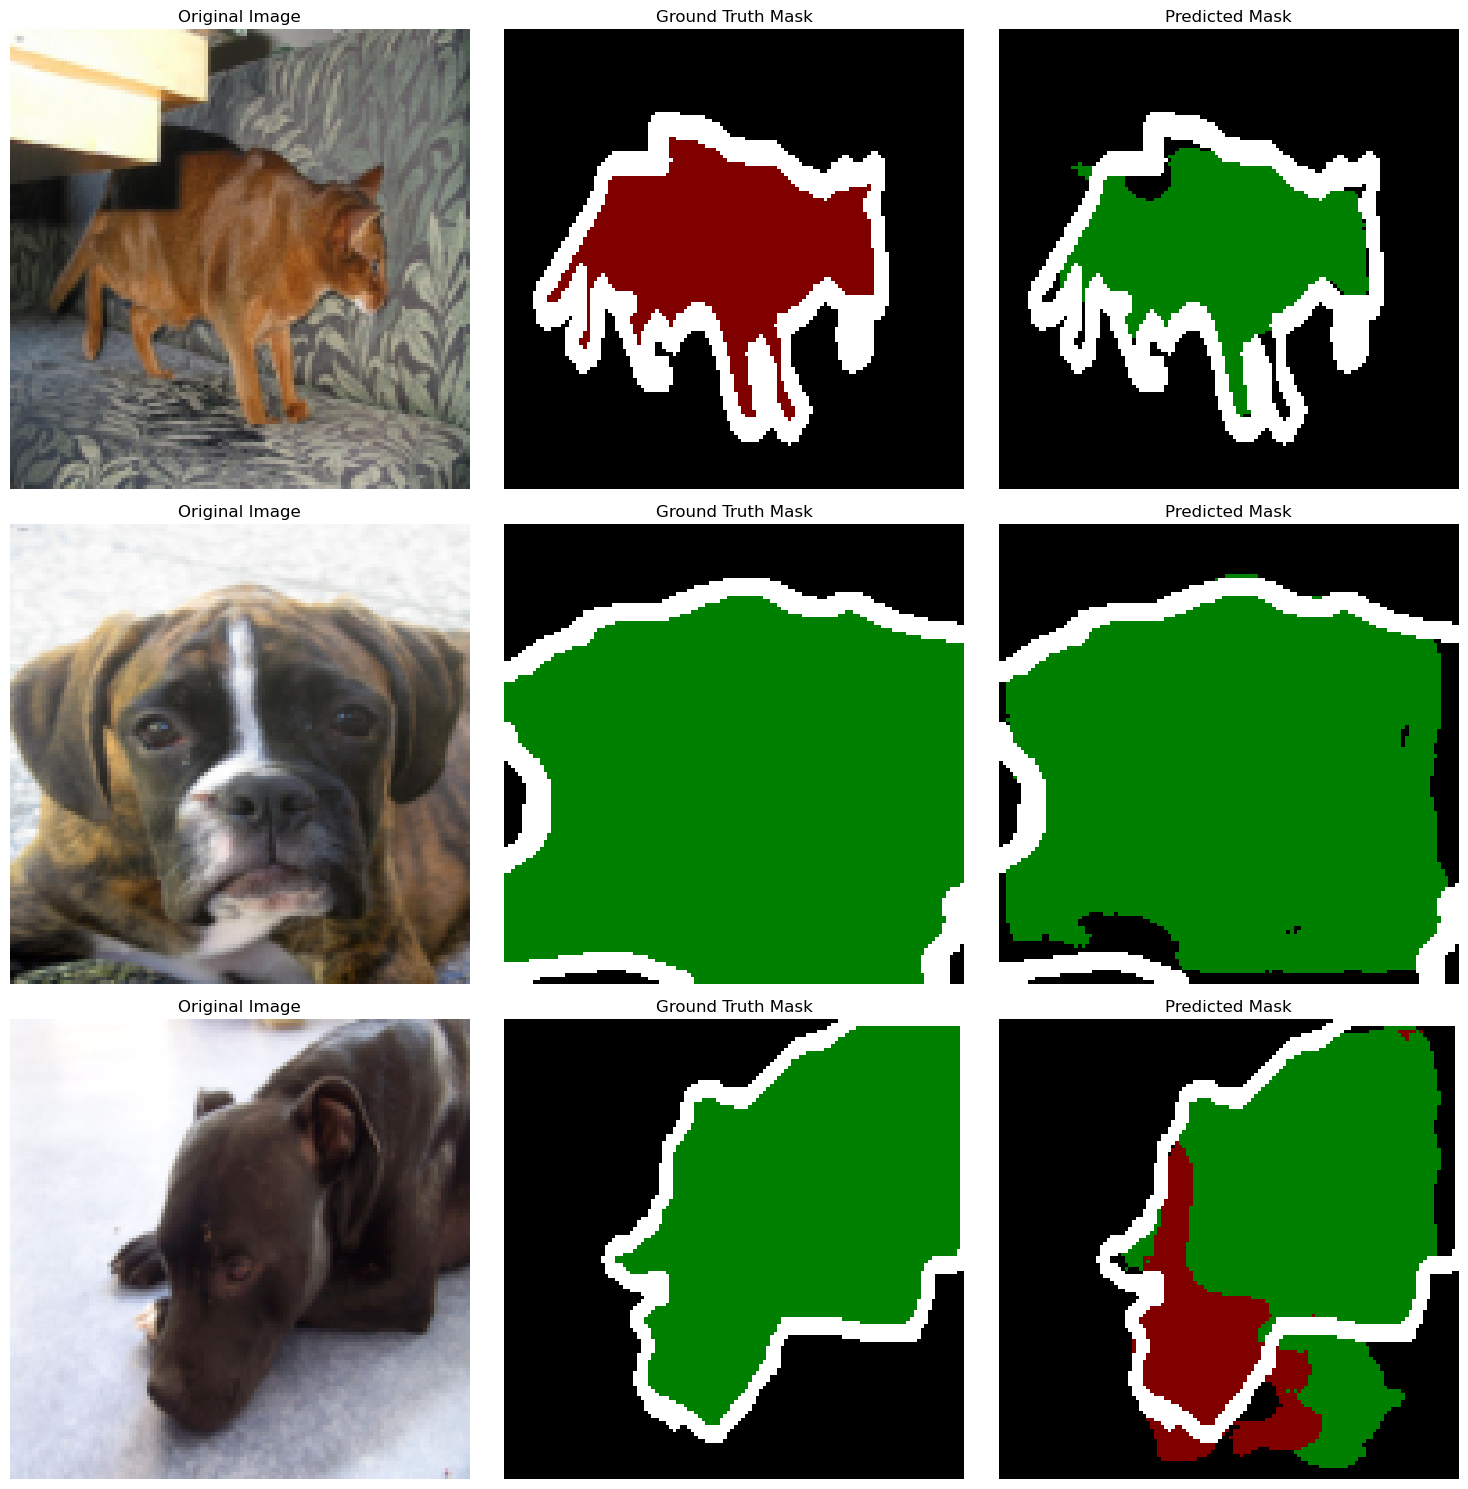

In [11]:
# Visualize results
print("\nVisualizing U-Net results on validation :")
visualize_unet_results(unet, val_loader, device, num_samples=3)

In [11]:
# Evaluate model on test set
# print("\nEvaluating U-Net on test set:")
# test_results = evaluate_unet(unet, test_loader, device)

In [12]:
# print("\nVisualizing U-Net results on test:")
# visualize_unet_results(unet, test_loader, device, num_samples=3)